# ML Prototype 

Time Estimate: 25 - 30 Hours / 50 - 60 Hours (depending on if you decide to build both prototypes)
The goal of this step is to find a machine learning or deep learning approach that works for your problem, and then show that the approach you choose is a viable one. Since the application has not been deployed to production yet, we’ll call it a prototype.

For this step, you’ll build your prototype in a Jupyter notebook. Depending on your problem, you’ll be using a more ‘traditional’ machine learning (ML) technique or a deep learning (DL) technique. Your goal is to come up with a working implementation of your prototype in a Jupyter notebook. This prototype could work on a subset of the data but demonstrates that your approach to solving the problem is a viable one based on the following criteria:
- The data has been reasonably split into training, validation, and test sets.
- You have used the correct metric(s) to evaluate the performance of your
algorithm.
- The performance of your algorithm is ‘good enough’ as determined by your mentor.

### Rubric

- The submission shows that the student understands how to design, implement, and justify a suitable machine learning and/or deep learning approach to a problem.
- The submission demonstrates that the student made thoughtful decisions about validating and testing the approach:
    - The data has been reasonably split into training, validation, and test sets
    - The ML/DL algorithm chosen for the approach makes sense in the context of the problem
    - The student has used the correct metric(s) to evaluate the performance of their algorithm
    - The performance of their algorithm is ‘good enough’ to meet the requirements of the business problem

- Well-documented GitHub repository and code. The Jupyter notebooks for the code provide step-by-step documentation that’s easy to follow. 

# ML Prototype

## Summary
In this section I explore the following questions:

- Q: What is the best classification objective for the call center use case and performance metric? 
- Q: What is the fastest model for prototyping? 
- Q: What is the minimal amount of training data to quickly assess performance?
- Q: What is the source of model confusion?
- Q: What is the effect of using the librosa features mel, mfcc, chroma, vs the precomputed MELD features?

Next I will present the ML prototype as part of a pipeline comprised of several ideas explored previously:
- feature extraction with best determined audio limit    
- oversampling using ADASYN to rectify class imbalance
- feature standardization using QuantileTransformer to correct mel features with right-skewed power-law distributions
- PCA to reduce dimensionality 
- Light Gradient Boosting model
    - optimizing with Bayesian hyperparameter search

In [1]:
from math import ceil, floor
import warnings
warnings.filterwarnings('ignore')
try:
    import pickle5 as pickle
except BaseException:
    import pickle

from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline 
try: 
    import librosa
except BaseException:
    pass
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (silhouette_score, f1_score, plot_confusion_matrix, 
                             plot_precision_recall_curve, precision_score, recall_score)
from sklearn.preprocessing import QuantileTransformer
from skopt import BayesSearchCV
from skopt.callbacks import TimerCallback, DeadlineStopper
from skopt.space import Real, Categorical, Integer
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn import init
from torch import nn
import torch.nn.functional as F
import torch
from tqdm.notebook import tqdm_notebook

Load dataset including raw audio and previously computed MELD features on best audio limit.

In [2]:
checkpoint_path = 'data/features/df.pkl'
with open(checkpoint_path, 'rb') as f:
    df = pickle.load(f)

In [3]:
extract_limit = df.extract_limit.values[0]  # previously found good audio limit
sr = df.sr.values[0] # sample rate

# NB cannot use select_dtypes since features are stored under *int* index *names*
X = df[[c for c in df.columns.values if isinstance(c, int)]] #  + ['audio', 'sr']

print('limit ', extract_limit)
print('sr ', sr)
print('X ', X.shape)

limit  110250
sr  22050.0
X  (13700, 160)


## Objective

In previous notebooks I focused on emotion classification, however I began to question the ability to achieve good performance using this objective. Furthermore, for the call center use case of flagging problematic calls quickly, it is acceptable to make a binary judgement regarding the call. Here I will explore 3 possible objectives: 
- emotion classification: neutral, ...
- sentiment classication: neutral, positive, negative
- negativity classification: negative, not-negative, where neutral and positive are mapped to 'not-negative'

In [4]:
df.Sentiment.value_counts() / sum(df.Sentiment.value_counts()) * 100

neutral     46.956204
negative    30.525547
positive    22.518248
Name: Sentiment, dtype: float64

In [5]:
def sentiment_to_negativity(v):
    return 1 if v.lower() == 'negative' else 0

df['negativity'] = df.Sentiment.apply(sentiment_to_negativity)
df[['Sentiment', 'negativity']].sample(10)

,Sentiment,negativity
1643,positive,0
6311,negative,1
8830,negative,1
8145,neutral,0
5089,neutral,0
5358,negative,1
15,positive,0
9782,neutral,0
888,positive,0
6291,neutral,0


In [6]:
df.negativity.value_counts() / df.negativity.value_counts().sum()

0    0.694745
1    0.305255
Name: negativity, dtype: float64

In [7]:
df.to_pickle(checkpoint_path)

### Baseline Classification Performance

In [17]:
baseline = dict()
labels = ('Emotion', 'Sentiment', 'negativity')
for label in labels:
    max_class = df[label].value_counts().idxmax()
    score = f1_score(df[label], [max_class] * len(df), average='weighted')
    baseline[label] = score
    print(f'{label} always predict "{max_class}" for f1={score:.4f}')

Emotion always predict "neutral" for f1=0.3001
Sentiment always predict "neutral" for f1=0.3001
negativity always predict "0" for f1=0.5696


Now I would to get a reminder of the performance from naive tree-based model...

In [18]:
naive = dict()
for label in labels:
    y = df[label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=0)
    obj = 'binary' if label == 'negativity' else 'multiclass'
    m = lgb.LGBMClassifier(objective=obj, class_weight='balanced', random_state=0, n_jobs=-1)
    m.fit(X_train, y_train)
    score = f1_score(y_test, m.predict(X_test), average='weighted')
    print(label, score)
    naive[label] = score

Emotion 0.32791397554436225
Sentiment 0.39965233182724624
negativity 0.6047747015178847


In [19]:
for label in labels:
    print(label, naive[label] - baseline[label])

Emotion 0.02784020335569426
Sentiment 0.09957855963857826
negativity 0.035166777135027916


Looks like Sentiment can be more easily classified but I will have to check the confusion matrix to see if this corresponds to the neutral/positive classes vs. the negative.

## Prototyping

I want to be able to quickly test ideas. First I will check model training speed of the various tree models I'd like to try.

In [36]:
%%timeit
lgb.LGBMClassifier(objective='multiclass', class_weight='balanced', random_state=0, n_jobs=-1).fit(X, y=df.Emotion)

2.95 s ± 88.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
%%timeit
lgb.LGBMClassifier(objective='multiclass', class_weight='balanced', random_state=0, n_jobs=-1).fit(X, y=df.Sentiment)

1.3 s ± 87.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
%%timeit
lgb.LGBMClassifier(objective='binary', class_weight='balanced', random_state=0, n_jobs=-1).fit(X, y=df.negativity)

446 ms ± 25.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
%%timeit
RandomForestClassifier(class_weight='balanced', random_state=0, n_jobs=-1).fit(X, y=df.Emotion)

2.96 s ± 69.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
%%timeit
RandomForestClassifier(class_weight='balanced', random_state=0, n_jobs=-1).fit(X, y=df.Sentiment)

2.42 s ± 26.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
%%timeit
RandomForestClassifier(class_weight='balanced', random_state=0, n_jobs=-1).fit(X, y=df.negativity)

2.09 s ± 119 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Results of speed test:
Objective-wise: Emotion > Sentiment > negativity. Model-wise, RF > LGBM

So I will focus on the LGBM on Sentiment and negativity labels.

### Subsampling

Can I reduce the training size and still get comparable performance in a short amount of time?
Specifically, I will look at the effect of train size on the std of cross-val scores. Also, the effect of train size on test set perf.

In [8]:
def get_model(binary: bool=False):
    obj = 'binary' if binary else 'multiclass'
    return lgb.LGBMClassifier(objective=obj, class_weight='balanced', random_state=0, n_jobs=-1)


def experiment_subsampling(sizes, X, y, binary=False):
    """For given range of training sizes, plots CV scores and test scores."""
    results = []
    for size in tqdm_notebook(sizes):
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=size, stratify=y, random_state=0)
        scores = cross_val_score(get_model(binary), X_train, y_train, scoring='f1_weighted', cv=5, n_jobs=-1)
        results.append((size, np.mean(scores), np.std(scores), scores))

    res_df = pd.DataFrame(results, columns=['size', 'mean-score', 'std', 'scores'])
    res_df.plot(x='size', y='mean-score', yerr='std');
    

(If you get "unsupported pickle protocol: 5" you'll have to restart notebook in py38 env =/)

  0%|          | 0/10 [00:00<?, ?it/s]

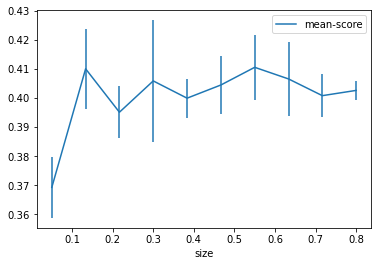

In [10]:
experiment_subsampling(np.linspace(0.05, 0.8, 10), X, y=df.Sentiment)

  0%|          | 0/10 [00:00<?, ?it/s]

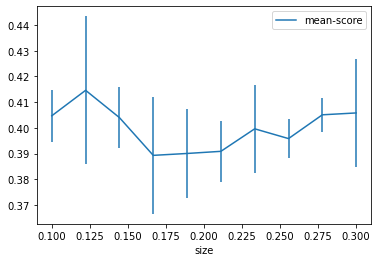

In [11]:
experiment_subsampling(np.linspace(0.1, 0.3, 10), X, y=df.Sentiment)

For Sentiment classification the CV variance and test score seems good for even with 10% of the data. The test score is better for more data is greater, but it's only about 0.01 F1.

  0%|          | 0/10 [00:00<?, ?it/s]

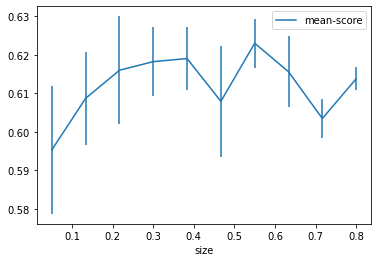

In [12]:
experiment_subsampling(np.linspace(0.05, 0.8, 10), X, y=df.negativity, binary=True)

  0%|          | 0/10 [00:00<?, ?it/s]

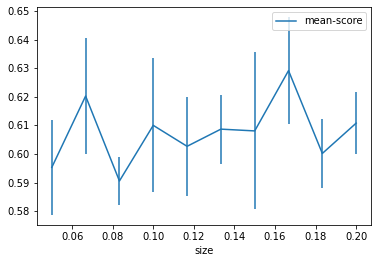

In [13]:
experiment_subsampling(np.linspace(0.05, 0.2, 10), X, y=df.negativity, binary=True)

About 10% of the data can also be sufficient in assessing negativity.

## Model Confusion

Let's take a close look at the errors in classification using the confusion matrix, precision, recall, and ROC AUC metrics.

Here I favor ROC AUC over PR AUC since the classes are not highly imbalanced (cf https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/)

### Sentiment

In [62]:
sent_model = get_model()
y = df.Sentiment
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=0)
sent_model.fit(X_train, y_train)
y_pred = sent_model.predict(X_test)

In [63]:
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f'prec={prec:.4f} rec={rec:.4f}'

'prec=0.3956 rec=0.4058'

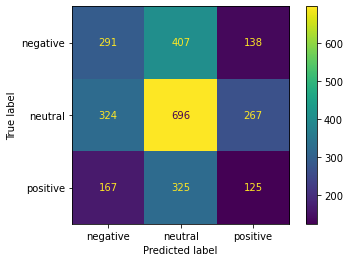

In [64]:
plot_confusion_matrix(sent_model, X_test, y_test);

Precision/recall are about the same. In the confusion matrix we see negative labels are getting confusing mainly as 'neutral' but also with positive.

Focusing on the negative class, there were 291 correct predictions, 545 false negatives, and 491 false positives

### Negativity 

In [66]:
neg_model = get_model(binary=True)
y = df.negativity
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=0)
neg_model.fit(X_train, y_train)
y_pred = neg_model.predict(X_test)

In [67]:
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f'prec={prec:.4f} rec={rec:.4f}'

'prec=0.6052 rec=0.6044'

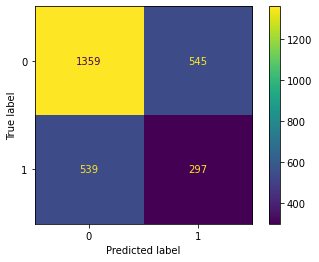

In [68]:
plot_confusion_matrix(neg_model, X_test, y_test);

For negativity the error types occur in equal number but the positive class is predicted much less accurately than the negative class.

There were slightly more true positives at 297 and about the same false negatives and false positives.

For educational purpose, here's the ROC curve for the classifier as well:

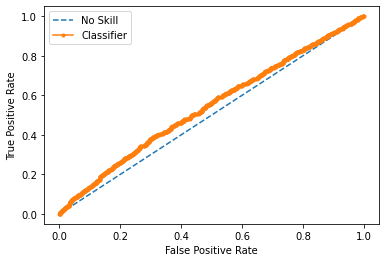

In [76]:
from sklearn.metrics import roc_curve, roc_auc_score

yhat = neg_model.predict_proba(X_test)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
fpr, tpr, _ = roc_curve(y_test, pos_probs)

plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show();

In [77]:
roc_auc_score(y_test, pos_probs)

0.544000165855816

## Librosa Feature vs. MELD features 

In the data wrangling notebook, I explored using melspectrogram, mfcc, and chroma features using the librosa library. The MELD data set provides its own precomptuted features described as:

audio_embeddings_feature_selection_emotion.pkl,audio_embeddings_feature_selection_sentiment.pkl - It consists of 1611/1422 dimensional audio feature vectors of each utterance trained for emotion/sentiment classification. These features are originally extracted from openSMILE and then followed by L2-based feature selection using SVM. It is a list comprising of 3 dictionaries for train, val and the test set with each dictionary indexed in the format dia_utt, where dia is the dialogue id and utt is the utterance id. For eg. train_audio_emb['0_0'].shape = (1611, ) or (1422, )

Here I will satisfy my curiosity as to whether the librosa features stack up to the MELD openSMILE features. 

In [79]:
import pickle

path = 'data/meld_features/audio_embeddings_feature_selection_{}.pkl'
all_features = []
for label in ('emotion', 'sentiment'):  
    f = path.format(label)
    datasets = pickle.load(open(f, 'rb'))
    for ds in datasets:
        tmp = pd.DataFrame(data=ds.items(), columns=['dia_utt', label + '_features'])
        all_features.append(tmp)
        print(label, ' size ', len(ds))

emotion  size  9989
emotion  size  1109
emotion  size  2610
sentiment  size  9989
sentiment  size  1109
sentiment  size  2610


In [80]:
for d in all_features:
    print(d.columns.values)

['dia_utt' 'emotion_features']
['dia_utt' 'emotion_features']
['dia_utt' 'emotion_features']
['dia_utt' 'sentiment_features']
['dia_utt' 'sentiment_features']
['dia_utt' 'sentiment_features']


In [81]:
from functools import reduce

train_df = pd.read_csv('data/train_labels.csv')
dev_df = pd.read_csv('data/dev_labels.csv')
test_df = pd.read_csv('data/test_labels.csv')
labels_dfs = (train_df, dev_df, test_df)

emo_features = all_features[:3]
sent_features = all_features[3:]

joins = []
for labels, emo_feats, sent_feats in zip(labels_dfs, emo_features, sent_features):
    cols = ['Dialogue_ID', 'Utterance_ID']
    labels['dia_utt'] = labels[cols].apply(lambda r: '_'.join(r.values.astype(str)), axis=1)
    
    # of the 6 feature sets we have join 1 here, later I will concat them into 1
    ds_joined = reduce(lambda a, b: pd.merge(a, b, on='dia_utt'), [labels, emo_feats, sent_feats])
    joins.append(ds_joined)

emb_df = pd.concat(joins)
emb_df.shape

(13708, 14)

In [82]:
emb_df.head(1)

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,dia_utt,emotion_features,sentiment_features
0,1,also I was the point person on my companys tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731",0_0,"[0.579978439650127, 0.9748008896749043, 0.1564...","[0.579978439650127, 0.9748008896749043, 0.1564..."


OK, so now I have loaded all the precomputed MELD features into a single DF.

In [83]:
from sklearn.preprocessing import LabelEncoder

y_emo = LabelEncoder().fit_transform(emb_df['Emotion'])
y_sent = LabelEncoder().fit_transform(emb_df['Sentiment'])
y_emo.shape, y_sent.shape

((13708,), (13708,))

In [84]:
X_emo = np.array([f for f in emb_df['emotion_features'].values])
X_sent = np.array([f for f in emb_df['sentiment_features'].values])
X_emo.shape, X_sent.shape

((13708, 1611), (13708, 1422))

In [85]:
from sklearn.metrics import silhouette_score

emo_sil = silhouette_score(X_emo, y_emo)
sent_sil = silhouette_score(X_sent, y_sent)

In [86]:
print('emo sil ', emo_sil, ' sent sil ', sent_sil)

emo sil  -0.01453310196481637  sent sil  -0.0018931991703444366


So these precomputed features have slightly better sil scores than the librosa features I computed in the earlier data exploration on emotion:
- mel -0.04264662
- mfcc -0.041319244
- chroma -0.030214868

I've never computed sentiment silhouette score before so I don't have a comparison with the librosa features.
Also, instead of 160 features as with librosa there are about 10X the number of precomputed features. Given this large number of features, I will try PCA to determine if they can be reduced.

In [87]:
def run_pca(X, y, c_s):
    scores = []
    for c in tqdm_notebook(c_s):
        pca = PCA(n_components=c)
        reduced = pca.fit_transform(X)
        scores.append(silhouette_score(reduced, y))   
    return scores

  0%|          | 0/15 [00:00<?, ?it/s]

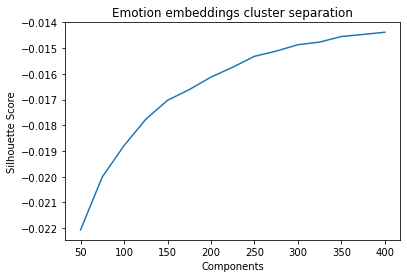

In [85]:
c_s = list(range(50, 411, 25))  # 1611
scores = run_pca(X_emo, y_emo, c_s)
plt.plot(c_s, scores)
plt.title('Emotion embeddings cluster separation')
plt.xlabel('Components')
plt.ylabel('Silhouette Score')
plt.show();

  0%|          | 0/15 [00:00<?, ?it/s]

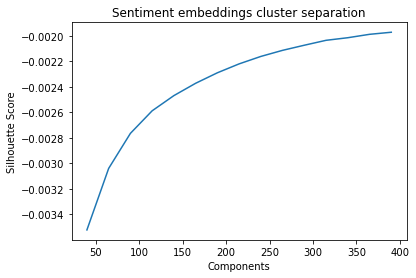

In [86]:
c_s = list(range(40, 411, 25))  # 1422
scores = run_pca(X_sent, y_sent, c_s)
plt.plot(c_s, scores)
plt.title('Sentiment embeddings cluster separation')
plt.xlabel('Components')
plt.ylabel('Silhouette Score')
plt.show();

The sentiment embeddings do better than the emotion embeddings. While there are way more features than 
librosa mel, mfcc, and chroma I can use PCA and reduce it to say 50 features without much drop in cluster separation.

I am curious to know how the sentiment embeddings perform with a model for the sentiment classification as compared to the scores from the librosa features found earlier.

In [89]:
sent_emb_model = get_model()
X_train, X_test, y_train, y_test = train_test_split(X_sent, y_sent, train_size=0.8, stratify=y_sent, random_state=0)
sent_emb_model.fit(X_train, y_train)
y_pred = sent_emb_model.predict(X_test)

In [90]:
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f'prec={prec:.4f} rec={rec:.4f}'

'prec=0.4970 rec=0.5109'

With the librosa features I got: 'prec=0.3956 rec=0.4058' which is about 0.1 higher in F1 score.

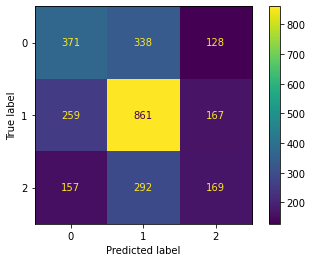

In [91]:
plot_confusion_matrix(sent_emb_model, X_test, y_test);

While 'better' in F1, the drawbacks of the MELD embeddings are:
- not easily reproducible 
- can't use partial / prefix audio
- larger number of features -> longer training time

But they do suggest that fine tuning the feature extraction could provide some small gains in performance. 

## Librosa Extraction Tuning

The following extraction hyperparameters can be tuned: 

mfcc 
- n_mfcc in [13, 26] 
- dct_type in [1, 2, 3]

chroma_stft
- n_fft=220 for .01 s and 2205 for .1 s, hop length can be 1/2 or 1/4 the window size
- hop_length
- m_chroma=12
- center=T/F

melspectrogram 
- n_fft=220 for .01 s and 2205 for .1 s, hop length can be 1/2 or 1/4 the window size
- hop_length


In [4]:
def extract_mfcc_mean(audio, sr, **kwargs):
    return np.mean(librosa.feature.mfcc(y=audio, sr=sr, **kwargs).T, axis=0)


def extract_chroma_mean(audio, sr, **kwargs):
    stft = np.abs(librosa.stft(audio))
    return np.mean(librosa.feature.chroma_stft(S=stft, sr=sr, **kwargs).T, axis=0)


def extract_mel_mean(audio, sr, **kwargs):
    return np.mean(librosa.feature.melspectrogram(y=audio, sr=sr, **kwargs).T, axis=0)
     

In [17]:
def run_extract(df, lim, func, **kwargs):
    X = []
    for i, r in df.iterrows():
        audio = r.audio if lim is None else r.audio[:lim]
        X.append(func(audio, r.sr, **kwargs))
    
    return np.array(X)

In [18]:
# test MFCC hyperparams
xs = list(range(10, 30, 2))
scores = list()
for n_mfcc in xs:   
    feats = run_extract(X_train, extract_limit, extract_mfcc, n_mfcc=n_mfcc)
    scores.append(silhouette_score(feats, y_train))

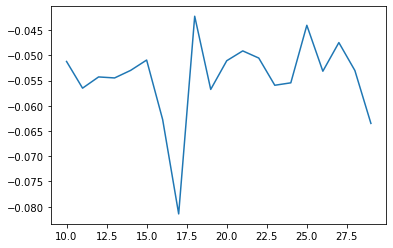

In [10]:
plt.plot(xs, scores);

Disregarding some weird transients, I do not see a strong reason to change the number of MFCC coeffincients from the typical default. 

In [28]:
# test chroma hyperparams
xs = list(range(2, 14))
scores = list()
for n_chroma in xs:  
    feats = run_extract(X_train, extract_limit, extract_chroma, n_chroma=n_chroma)
    scores.append(silhouette_score(feats, y_train))

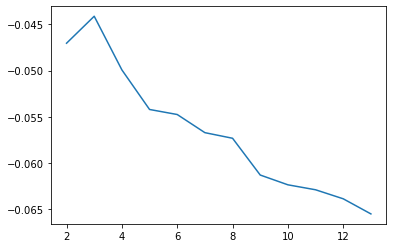

In [29]:
plt.plot(xs, scores);

Interestingly, decreasing the number of chroma appears to improve the class separation a small amount.

## ML Prototype

Pipeline
- oversampling using ADASYN
- feature standardization using Quantile Transformer
- PCA (search components)
- LGBM
    - thorough hyperparameter search with skoptimize



In [7]:
y = df.negativity

Since I changed several things since I last ran PCA, here I will run a simple search again on the number of components.

In [22]:
pipe = Pipeline([
    ('oversample', ADASYN(random_state=0, n_jobs=-1)), 
    ('standardize', QuantileTransformer(output_distribution='normal', random_state=0)),
    ('decomposition', PCA(random_state=0)),
    ('estimator', lgb.LGBMClassifier(objective='binary', class_weight='balanced', random_state=0, n_jobs=-1)),
])
params = {
    'decomposition__n_components': list(range(10, 60)) 
}
search = GridSearchCV(pipe, params, scoring='f1_weighted', cv=5, n_jobs=-1, verbose=1) 

search.fit(X, y)

search.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  3.1min finished


{'decomposition__n_components': 51}

In [19]:
def grid_search_plot(search, x, hue=None, col=None):
    result_df = pd.DataFrame.from_dict(search.cv_results_, orient='columns')
    grid = sns.relplot(data=result_df,
                kind='line',
                x='param_' + x,
                y='mean_test_score',
                hue='param_' + hue if hue else None, 
                col='param_' + col if col else None)
    grid.fig.set_size_inches(15, 10)


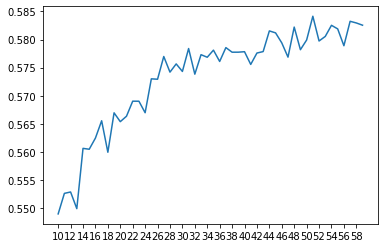

In [35]:
xs = search.cv_results_['param_decomposition__n_components'].data
ax = plt.plot(xs, search.cv_results_['mean_test_score'])
plt.xticks(np.arange(min(xs), max(xs) + 1, 2.0));

Looks like 50 components is a good tradeoff between components and score. 

Next I will tune the LGBMClassifier using Bayesian Optimization. Now, since this isn't a simple grid search, I will reduce the training data to a smaller amount as suggested by the earlier experiments.

In [10]:
y = df.negativity
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, stratify=y, random_state=0)

In [6]:
lgb.__version__

'3.2.1'

In [7]:
n_components = 50
pipe = Pipeline([
    ('oversample', ADASYN(random_state=0, n_jobs=-1)),  # generates synthetic data
    ('standardize', QuantileTransformer(output_distribution='normal', random_state=0)),
    ('decomposition', PCA(random_state=0, n_components=n_components)),
    ('model', lgb.LGBMClassifier(objective='binary', metric='binary_logloss', class_weight='balanced', 
                                 random_state=0, n_jobs=-1)),
])

# https://lightgbm.readthedocs.io/en/v3.2.1/pythonapi/lightgbm.LGBMClassifier.html
search_spaces = {
        # Power
        'model__num_leaves': Integer(10, 100),                                       # def=31
        'model__n_estimators': Integer(low=50, high=500),                            # def=100    
        'model__max_depth': Integer(1, 30),                                          # def=-1 no limit
    
        # Learning
        'model__boosting_type': Categorical(['gbdt', 'dart', 'goss']),               # def=gbdt
        'model__learning_rate': Real(low=0.001, high=0.5, prior='log-uniform'),      # def=0.1
        'model__min_split_gain': Real(0.0, 1.0),                                     # def=0
        'model__min_child_weight': Real(low=0.00001, high=0.1, prior='log-uniform'), # def=1e-3
        'model__min_child_samples': Integer(10, 30),                                 # def=20
    
        # Bagging
        # fraction of training samples used to train 
        'model__subsample': Real(0.8, 1.0),                                          # def=1.0
        # fraction of features used to train
        'model__colsample_bytree': Real(0.8, 1.0),                                   # def=1.0
        # bagging frequency, can't bag with 'goss'
        'model__subsample_freq': Integer(0, 5),                                      # def=0
    
        # regularization
        'model__reg_alpha': Integer(0, 100),                                         # def=0
        'model__reg_lambda': Integer(0, 100),                                        # def=0
}

This is 13 hyperparameters which is a lot to train simultaneously. Perhaps some have complex interactions. To make it tractiable I will group these 13 into subgroups and run separate Bayes searches on these subgroups first.

Power/Time HPs - trade off model power with training time
- num_leaves
- n_estimators
- max_depth

Learning HPs
- boosting_type
- learning_rate
- min_split_gain
- min_child_weight
- min_child_samples

Subsampling/Bagging HPs
- subsample
- colsample_bytree
- subsample_freq

Regularization HPs - if overfitting is found, try optimizing these
- alpha
- lambda

In [13]:
def bayes_search(X, y, pipe, spaces: dict, n_iter:int, refit=False):
    """Wrapper to simplify hyperparameter experimentation"""
    budget_minutes = 120 # time-based stopping criterion
    cbs = [TimerCallback(), DeadlineStopper(60 * budget_minutes)]
    opt = BayesSearchCV(
        estimator=pipe,
        search_spaces=spaces,
        n_iter=n_iter,
        scoring='f1_weighted',
        n_jobs=-1,
        n_points=1,  # number of parameter settings to sample in parallel
        refit=refit,  # after opt, refits on entire dataset, so predictions can be made
        verbose=0,
        cv=3
    )
    res = opt.fit(X, y, callback=cbs)
    iter_times = cbs[0].iter_time
    print(f'elapsed time: {sum(iter_times)/60:.2f}m ave-iter={np.mean(iter_times):.2f}s')
    return res

Calculate iterations based on time I want to wait: 10 minutes.

In [31]:
ave_iter = 8
n_iter = int(10 * 60 / ave_iter) 
n_iter

75

### Power spaces

In [23]:
power_spaces = {
    'model__num_leaves': Integer(10, 100),                                       # def=31
    'model__n_estimators': Integer(low=50, high=500),                            # def=100    
    'model__max_depth': Integer(1, 30),                                          # def=-1 no limit
}

In [24]:
power_search = bayes_search(X_train, y_train, pipe, 
     spaces=power_spaces, 
     n_iter=n_iter
)

elapsed time: 1440.97s ave-iter=7.96s


In [16]:
# (bayes search CV runs in parallel so can't use skopt's plot_convergence)

def plot_spaces(search): 
    score = 'mean_test_score'
    for space in search.search_spaces:
        plt.scatter(search.cv_results_['param_' + space], search.cv_results_[score])  
        plt.xlabel(space.replace('model__', ''))
        plt.ylabel(score)
        plt.show();

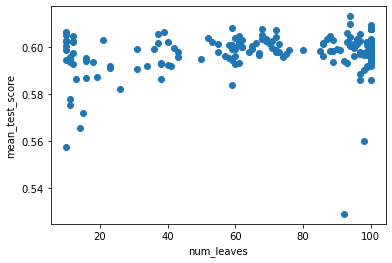

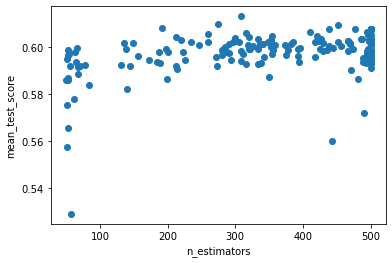

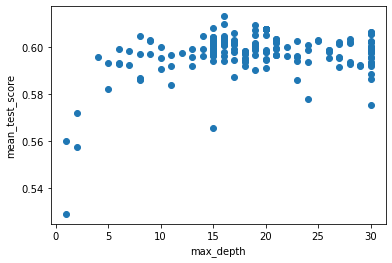

In [27]:
plot_spaces(power_search)

Based on these scatterplots, looks like the HPs do well as follows:
- num_leaves around 90
- n_estimators around 300
- max_depth around 16

In [29]:
power_search.best_score_

0.6130586263982497

In [30]:
power_search.best_params_

OrderedDict([('model__max_depth', 16),
             ('model__n_estimators', 309),
             ('model__num_leaves', 94)])

### Learning Spaces

In [33]:
learning_spaces = {
    'model__boosting_type': Categorical(['gbdt', 'dart', 'goss']),               # def=gbdt
    'model__learning_rate': Real(low=0.001, high=0.5, prior='log-uniform'),      # def=0.1
    'model__min_split_gain': Real(0.0, 1.0),                                     # def=0
    'model__min_child_weight': Real(low=0.00001, high=0.1, prior='log-uniform'), # def=1e-3
    'model__min_child_samples': Integer(10, 30),                                 # def=20
}

In [36]:
ave_iter = 2.5
minutes = 10
n_iter = int(minutes * 60 / ave_iter) 
n_iter

240

In [37]:
learn_search = bayes_search(X_train, y_train, pipe, 
     spaces=learning_spaces, 
     n_iter=n_iter
)

elapsed time: 2205.53s ave-iter=9.19s


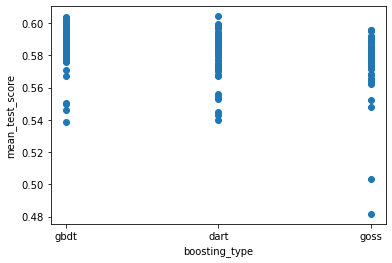

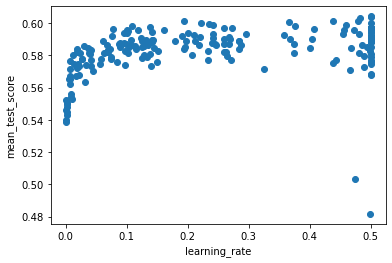

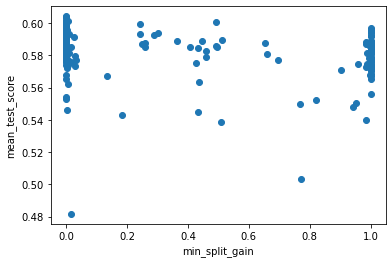

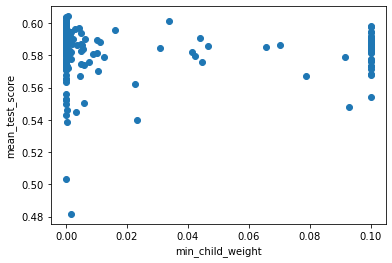

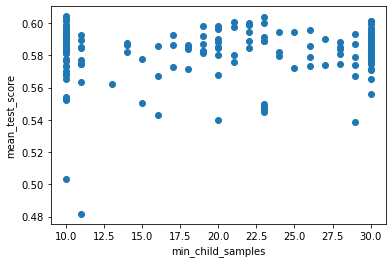

0.604231457299018
OrderedDict([('model__boosting_type', 'dart'), ('model__learning_rate', 0.49999999999999994), ('model__min_child_samples', 10), ('model__min_child_weight', 0.00048787896303663565), ('model__min_split_gain', 0.0)])


In [38]:
plot_spaces(learn_search)
print(learn_search.best_score_)
print(learn_search.best_params_)

- boosting type we have dart > gbdt > goss. Perhaps GBDT has a better average score so perhaps worth checking out again later.
- Learning rate is best at 0.5 but even 0.1 is still good.
- min split gain best at 0.0 so let's keep the model simple
- min_child_weight best at 0.0004878 which is close to default, so perhaps just a small exploration around that range
- min_child_samples - oddly 10 or 30 does well when the default is 20

### Bagging Spaces

In [42]:
ave_iter = 2.2
minutes = 10
n_iter = int(minutes * 60 / ave_iter) 
n_iter

272

In [43]:
bag_spaces = {
    # fraction of training samples used to train 
    'model__subsample': Real(0.8, 1.0),                                          # def=1.0
    # fraction of features used to train
    'model__colsample_bytree': Real(0.8, 1.0),                                   # def=1.0
    # bagging frequency, can't bag with 'goss'
    'model__subsample_freq': Integer(0, 5),                                      # def=0
}

In [45]:
bag_search = bayes_search(X_train, y_train, pipe, 
     spaces=bag_spaces, 
     n_iter=n_iter
)

elapsed time: 2483.32s ave-iter=9.13s


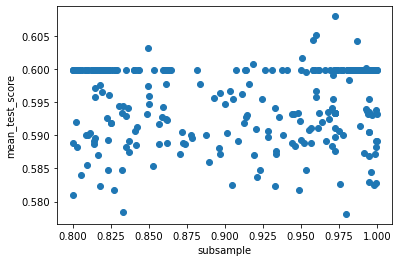

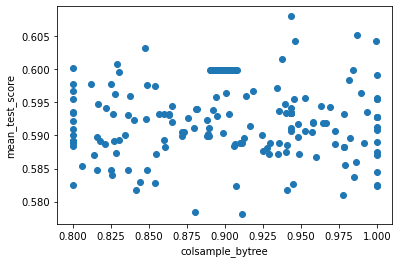

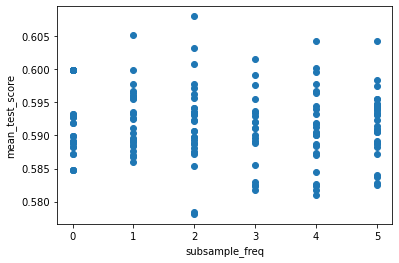

0.6079253627355077
OrderedDict([('model__colsample_bytree', 0.9437375451733251), ('model__subsample', 0.972764560061613), ('model__subsample_freq', 2)])


In [46]:
plot_spaces(bag_search)
print(bag_search.best_score_)
print(bag_search.best_params_)

- subsample~=.97
- colsample_bytree~=.94
- subsample_freq=2

### Power/Learning/Bagging combined

Here I will do one more search using narrow ranges from the 3 previous sections

In [54]:
combined_spaces = {
    # Power
    'model__num_leaves': Integer(90, 100),                                       # def=31
    'model__n_estimators': Integer(low=300, high=320),                           # def=100    
    'model__max_depth': Integer(14, 18),                                         # def=-1 no limit

    # Learning
    'model__boosting_type': Categorical(['gbdt', 'dart']),                       # def=gbdt
    'model__learning_rate': Real(low=0.001, high=0.5, prior='log-uniform'),      # def=0.1
    # 'model__min_split_gain': Real(0.0, 1.0),                                     # def=0
    'model__min_child_weight': Real(low=0.00001, high=0.001, prior='log-uniform'), # def=1e-3
    'model__min_child_samples': Integer(10, 30),                                 # def=20

    # Bagging
    'model__subsample': Real(0.96, 0.98),                                          # def=1.0
    'model__colsample_bytree': Real(0.92, 0.96),                                   # def=1.0
    'model__subsample_freq': Categorical([2]),                                      # def=0
}

In [55]:
ave_iter = 9
minutes = 20
n_iter = int(minutes * 60 / ave_iter) 
n_iter

133

In [56]:
combo_search = bayes_search(X_train, y_train, pipe, 
     spaces=combined_spaces, 
     n_iter=n_iter
)

elapsed time: 1284.66s ave-iter=9.66s


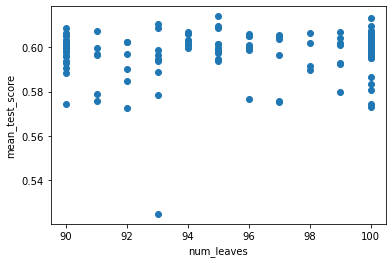

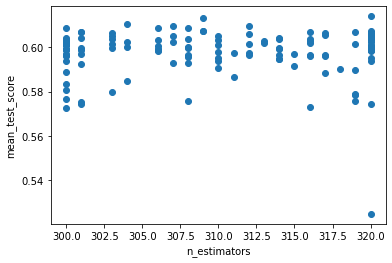

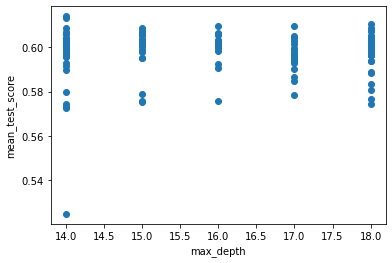

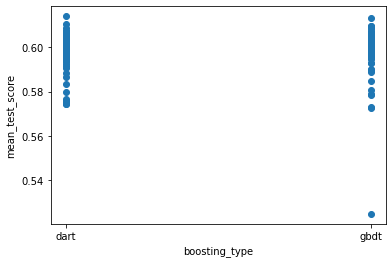

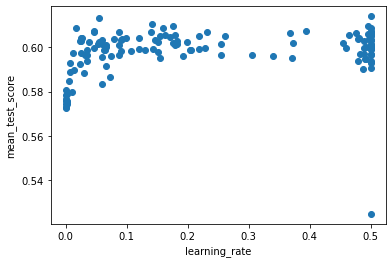

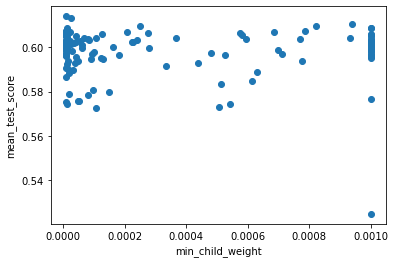

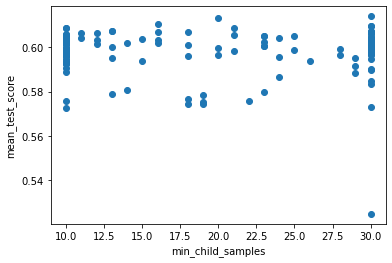

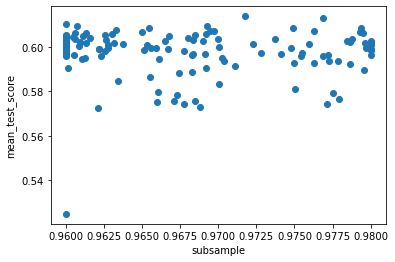

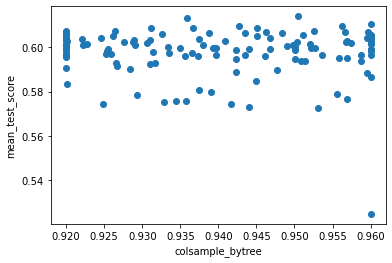

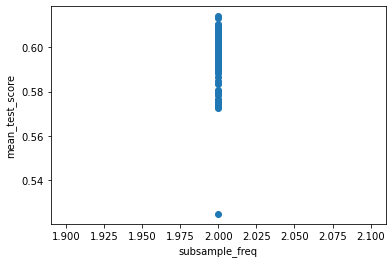

0.6138716881065324
OrderedDict([('model__boosting_type', 'dart'), ('model__colsample_bytree', 0.9504917538207562), ('model__learning_rate', 0.49999999999999994), ('model__max_depth', 14), ('model__min_child_samples', 30), ('model__min_child_weight', 1e-05), ('model__n_estimators', 320), ('model__num_leaves', 95), ('model__subsample', 0.9717536799682245), ('model__subsample_freq', 2)])


In [58]:
plot_spaces(combo_search)
print(combo_search.best_score_)
print(combo_search.best_params_)

The best F1 score is 0.61387 as compared to the zero-rule baseline of 0.5696 and the naive LGBM baseline of 0.60477. So there is some, but not significant improvement, from running these searches.

Next I will check whether there is overfitting...

In [5]:
def get_opt_lgbm(reg_alpha=0.0, reg_lambda=0.0):
    return lgb.LGBMClassifier(objective='binary', class_weight='balanced', random_state=0, n_jobs=-1,
        num_leaves=95,
        n_estimators=320,
        max_depth=14,
        boosting_type='dart',
        learning_rate=0.5,
        min_split_gain=0,
        min_child_weight=1e-05,
        min_child_samples=30,
        subsample=0.97175,
        colsample_bytree=0.95,
        subsample_freq=2,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda
    )

In [6]:
def get_pipe(reg_alpha=0.0, reg_lambda=0.0):
    return Pipeline([
        ('oversample', ADASYN(random_state=0, n_jobs=-1)), 
        ('standardize', QuantileTransformer(output_distribution='normal', random_state=0)),
        ('decomposition', PCA(n_components=50, random_state=0)),
        ('model', get_opt_lgbm(reg_alpha, reg_lambda)),
    ])

In [11]:
pipe = get_pipe()
pipe.fit(X_train, y_train)
train_score = f1_score(y_train, pipe.predict(X_train), average='weighted')
test_score = f1_score(y_test, pipe.predict(X_test), average='weighted')
train_score, test_score

(0.9992703172471006, 0.6088280140373893)

The training set has been basically learned, and the test score at 0.60883 is slightly worse than the best CV score from Bayes search of 0.61387. I will do a quick try of regularization to get familiar with it...

### Regularization

In [14]:
reg_space = {      
    'model__reg_alpha': Integer(0, 100),                                         # def=0
    'model__reg_lambda': Integer(0, 100),                                        # def=0
}

ave_iter = 8.06
minutes = 10
n_iter = int(minutes * 60 / ave_iter) 
reg_search = bayes_search(X_train, y_train, get_pipe(), 
     spaces=reg_space, 
     n_iter=n_iter
)

elapsed time: 5.21m ave-iter=4.23s


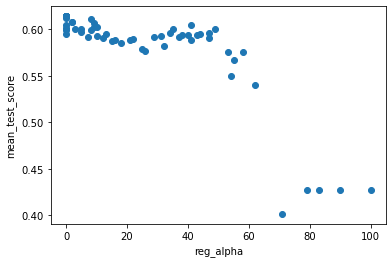

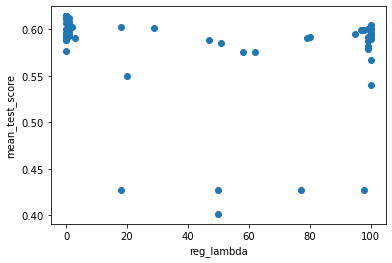

0.6138716881065324
OrderedDict([('model__reg_alpha', 0), ('model__reg_lambda', 0)])


In [17]:
plot_spaces(reg_search)
print(reg_search.best_score_)
print(reg_search.best_params_)

Based on the regularization search, it appears there is not much overfitting that can be ameliorated by regularization.

## Conclusion

In this notebook I developed a machine learning prototype to quickly detect problems on calls for a fictional call center company. I used the MELD dataset, librosa audio features, and light gradient boosting model to improve performance over baseline.

I detail, I determined the following
- best classification objective was negativity over emotion and sentiment
- LGBM was faster than RandomForest for prototyping
- About 10% of the data can be sufficient to train for negativity classification
- librosa features don't give quite as good performance as those supplied by MELD, but are fewer in number and allow us to experiment with the length of audio
- using bayes optimization, f1 = 0.6088 was obtained on the test data over zero-rule baseline of f1=0.5696 and over naive model of f1=0.6048